In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklift.datasets import fetch_x5

# Получение датасета

In [2]:
dataset = fetch_x5()

data = dataset.data

# Данные обо всех клиентах
clients = data.clients
# Клиенты для обучения
train = data.train           
# Информация о покупках
purchases = data.purchases

# Тритмент
treatement = dataset.treatment
# Целевая переменная
target = dataset.target

In [3]:
# Информация о клиентах
df_clients = pd.concat([train, treatement, target], axis=1)
df_clients = pd.merge(df_clients, clients, left_on='client_id', right_on='client_id')

In [4]:
df_clients

,client_id,treatment_flg,target,first_issue_date,first_redeem_date,age,gender
0,000012768d,0,1,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,1,1,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,1,1,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,1,1,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,1,1,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U
...,...,...,...,...,...,...,...
200034,fffe0abb97,0,0,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F
200035,fffe0ed719,0,1,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U
200036,fffea1204c,0,1,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F
200037,fffeca6d22,1,0,2017-12-28 11:56:13,NaN,77,F


In [5]:
purchases

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45786563,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,24d5a54f42,1.0,164.0,NaN
45786564,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,7427d0830d,1.0,134.0,NaN
45786565,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,6c547c2ca8,1.0,60.0,NaN
45786566,fffff6ce77,48f6d115ce,2019-03-15 17:47:02,6.7,0.0,0.0,0.0,676.0,5ec64bdccb,d04e7a8338,1.0,48.0,NaN


# Проверка на пропуски

In [6]:
df_clients.isna().sum()

client_id                0
treatment_flg            0
target                   0
first_issue_date         0
first_redeem_date    17546
age                      0
gender                   0
dtype: int64

Пропуски есть только в `first_redeem_date`. Они обозначают, что событие `redeem` никогда не произошло. Их заполнять не надо.

In [7]:
purchases.isna().sum()

client_id                         0
transaction_id                    0
transaction_datetime              0
regular_points_received           0
express_points_received           0
regular_points_spent              0
express_points_spent              0
purchase_sum                      0
store_id                          0
product_id                        0
product_quantity                  0
trn_sum_from_iss                  0
trn_sum_from_red           42743212
dtype: int64

Пропуски есть только в `trn_sum_from_red`, что обозначает стоимость товара до применения баллов. Равно `NaN` там, где человек не применил баллы. Можно восстановить по значению `trn_sum_from_iss` (стоимость товара после применения баллов).

In [8]:
purchases['trn_sum_from_red'] = purchases['trn_sum_from_red'].fillna(purchases['trn_sum_from_iss'])

In [9]:
# Преобразование значение потраченных баллов из отрицательных в положительные (для удобства)
purchases['regular_points_spent'] = purchases['regular_points_spent'].abs()
purchases['express_points_spent'] = purchases['express_points_spent'].abs()

In [10]:
purchases.isna().sum()

client_id                  0
transaction_id             0
transaction_datetime       0
regular_points_received    0
express_points_received    0
regular_points_spent       0
express_points_spent       0
purchase_sum               0
store_id                   0
product_id                 0
product_quantity           0
trn_sum_from_iss           0
trn_sum_from_red           0
dtype: int64

Теперь пропусков нет.

# Распределение таргета

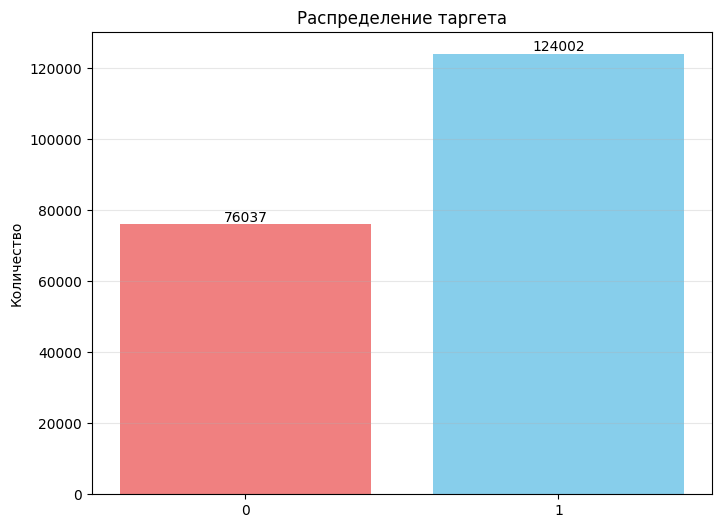

In [11]:
# Подсчет частот
value_counts = target.value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values, color=['lightcoral', 'skyblue'])
plt.ylabel('Количество')
plt.title('Распределение таргета')
plt.xticks([0, 1], ['0', '1'])
plt.grid(axis='y', alpha=0.3)

# Добавление подписей с значениями
for i, v in enumerate(value_counts.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

# Feature engineering

In [12]:
class BehavioralFeatureGenerator:
    """
    Класс для генерации агрегированных поведенческих признаков
    на основе транзакционных данных (таблица purchases).
    """
    def __init__(self, purchases_df):
        self.df = purchases_df.copy()

    # Получить уникальные транзакции (без дублирования по product_id)
    def _get_unique_transactions(self):
        cols_to_keep = ['client_id', 'transaction_id', 'transaction_datetime', 
                       'regular_points_received', 'express_points_received',
                       'regular_points_spent', 'express_points_spent', 
                       'purchase_sum', 'store_id']
        
        return self.df[cols_to_keep].drop_duplicates('transaction_id')

    # Получить данные на уровне конкретных продуктов
    def _get_product_level_data(self):
        product_cols = ['client_id', 'transaction_id', 'product_id', 
                       'product_quantity', 'trn_sum_from_iss', 'trn_sum_from_red']
        return self.df[product_cols]

    # Генерация всех фич
    def generate_features(self):
        features = {}
        
        # Базовые фичи по транзакциям
        features.update(self._transaction_features())
        
        # Фичи по баллам
        features.update(self._points_features())
        
        # Фичи по продуктам
        features.update(self._product_features())
        
        # Временные фичи
        features.update(self._time_features())
        
        # Фичи по магазинам
        features.update(self._store_features())
        
        return pd.DataFrame(features)

    # Фичи по транзакциям
    def _transaction_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'total_transactions': client_trans.size(),
            'total_purchase_sum': client_trans['purchase_sum'].sum(),
            'avg_transaction_amount': client_trans['purchase_sum'].mean(),
            'std_transaction_amount': client_trans['purchase_sum'].std(),
            'max_transaction_amount': client_trans['purchase_sum'].max(),
            'min_transaction_amount': client_trans['purchase_sum'].min(),
        }
        
        # Квантили
        for q in [0.25, 0.5, 0.75]:
            features[f'transaction_amount_q{q}'] = client_trans['purchase_sum'].quantile(q)
        
        return features

    # Фичи по баллам
    def _points_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'total_regular_points_received': client_trans['regular_points_received'].sum(),
            'total_express_points_received': client_trans['express_points_received'].sum(),
            'total_regular_points_spent': client_trans['regular_points_spent'].sum(),
            'total_express_points_spent': client_trans['express_points_spent'].sum(),
            'avg_regular_points_per_transaction': client_trans['regular_points_received'].mean(),
            'avg_express_points_per_transaction': client_trans['express_points_received'].mean(),
            'points_earned_to_spent_ratio': (client_trans['regular_points_received'].sum() + 
                                           client_trans['express_points_received'].sum()) / 
                                          (client_trans['regular_points_spent'].sum() + 
                                           client_trans['express_points_spent'].sum() + 1)  # +1 чтобы избежать деления на 0
        }
        
        return features

    # Фичи по продуктам
    def _product_features(self):
        product_df = self._get_product_level_data()
        client_products = product_df.groupby('client_id')
        
        features = {
            'total_products_purchased': client_products['product_quantity'].sum(),
            'unique_products_count': client_products['product_id'].nunique(),
            'total_trn_sum_from_iss': client_products['trn_sum_from_iss'].sum(),
            'total_trn_sum_from_red': client_products['trn_sum_from_red'].sum(),
            'avg_product_quantity': client_products['product_quantity'].mean(),
        }
        
        return features

    # Временные фичи
    def _time_features(self):
        trans_df = self._get_unique_transactions()
        trans_df['transaction_datetime'] = pd.to_datetime(trans_df['transaction_datetime'])
        
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'first_transaction_date': client_trans['transaction_datetime'].min(),
            'last_transaction_date': client_trans['transaction_datetime'].max(),
            'transaction_period_days': (client_trans['transaction_datetime'].max() - 
                                      client_trans['transaction_datetime'].min()).dt.days,
        }
        
        features['transactions_per_day'] = (client_trans.size() / 
                                          (features['transaction_period_days'] + 1))
        
        # День недели и время суток
        trans_df['transaction_weekday'] = trans_df['transaction_datetime'].dt.dayofweek
        trans_df['transaction_hour'] = trans_df['transaction_datetime'].dt.hour
        
        # Самый частый день недели и час
        features['most_frequent_weekday'] = trans_df.groupby('client_id')['transaction_weekday'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
        )
        features['most_frequent_hour'] = trans_df.groupby('client_id')['transaction_hour'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
        )
        
        return features

    # Фичи по магазинам
    def _store_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        
        features = {
            'unique_stores_visited': client_trans['store_id'].nunique(),
            'most_frequent_store': client_trans['store_id'].agg(
                lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
            ),
            'store_loyalty_ratio': client_trans['store_id'].agg(
                lambda x: x.value_counts().iloc[0] / len(x) if len(x) > 0 else 0
            )
        }
        
        return features


In [13]:
class StaticFeatureGenerator:
    """
    Класс для извлечения и генерации статических признаков
    на основе данных о клиентах (таблица df_clients).
    """
    def __init__(self, clients_info_df):
        self.df = clients_info_df.copy()

    def generate_features(self):
        # Индекс для удобства
        df_indexed = self.df.set_index('client_id')
        
        features = pd.DataFrame(index=df_indexed.index)
        
        # Признаки из дат
        features['first_issue_month'] = pd.to_datetime(df_indexed['first_issue_date']).dt.month
        features['first_issue_weekday'] = pd.to_datetime(df_indexed['first_issue_date']).dt.dayofweek    
        # Разница в днях между активацией и первым использованием
        # Если не было использования, ставится пропуск
        features['redeem_lag_days'] = (pd.to_datetime(df_indexed['first_redeem_date']) - pd.to_datetime(df_indexed['first_issue_date'])).dt.days
        
        # Дамми для категориальных признаков
        gender_dummies = pd.get_dummies(df_indexed['gender'], prefix='gender')
        features = features.join(gender_dummies)
        
        return features

In [14]:
# Генерация поведенческих фичей
behavioral_gen = BehavioralFeatureGenerator(purchases)
behavioral_features_df = behavioral_gen.generate_features()
print(f"Сгенерировано {behavioral_features_df.shape[1]} поведенческих признаков.")

Сгенерировано 30 поведенческих признаков.


In [15]:
# Генерация статических фичей
static_gen = StaticFeatureGenerator(df_clients)
static_features_df = static_gen.generate_features()
print(f"Сгенерировано {static_features_df.shape[1]} статических признаков.")

Сгенерировано 6 статических признаков.


In [16]:
# Объединение всех данных в один датафрейм с признаками
final_df_for_analysis = df_clients.set_index('client_id').join([static_features_df, behavioral_features_df])
print(f"\nИтоговый датафрейм для анализа имеет размер: {final_df_for_analysis.shape}")


Итоговый датафрейм для анализа имеет размер: (200039, 42)


In [17]:
final_df_for_analysis.head()

,treatment_flg,target,first_issue_date,first_redeem_date,age,gender,first_issue_month,first_issue_weekday,redeem_lag_days,gender_F,...,avg_product_quantity,first_transaction_date,last_transaction_date,transaction_period_days,transactions_per_day,most_frequent_weekday,most_frequent_hour,unique_stores_visited,most_frequent_store,store_loyalty_ratio
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0.0,1.0,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,U,8.0,5.0,152.0,False,...,1.038462,2018-12-01 07:12:45,2019-03-14 15:01:47,103,0.038462,3,7,3,017c89b915,0.500000
000036f903,1.0,1.0,2017-04-10 13:54:23,2017-04-23 12:37:56,72.0,F,4.0,0.0,12.0,True,...,1.043210,2018-11-28 10:48:36,2019-03-17 10:29:37,108,0.293578,6,10,5,6381a55c22,0.781250
00010925a5,1.0,1.0,2018-07-24 16:21:29,2018-09-14 16:12:49,83.0,U,7.0,1.0,51.0,False,...,1.012821,2018-11-25 10:56:18,2019-03-08 07:09:50,102,0.174757,1,9,2,76d287ce03,0.611111
0001f552b0,1.0,1.0,2017-06-30 19:20:38,2018-08-28 12:59:45,33.0,F,6.0,4.0,423.0,True,...,1.232558,2018-11-24 07:14:43,2019-03-16 10:54:02,112,0.132743,5,10,4,f845376c1e,0.666667
00020e7b18,1.0,1.0,2017-11-27 11:41:45,2018-01-10 17:50:05,73.0,U,11.0,0.0,44.0,False,...,1.448529,2018-11-23 08:21:26,2019-03-15 12:04:23,112,0.159292,2,8,4,cb2449f7ad,0.666667


In [18]:
# Проверка на случай пропусков
final_df_for_analysis.isna().sum()

treatment_flg                             0
target                                    0
first_issue_date                          0
first_redeem_date                     17546
age                                       0
gender                                    0
first_issue_month                         0
first_issue_weekday                       0
redeem_lag_days                       17546
gender_F                                  0
gender_M                                  0
gender_U                                  0
total_transactions                        0
total_purchase_sum                        0
avg_transaction_amount                    0
std_transaction_amount                 3820
max_transaction_amount                    0
min_transaction_amount                    0
transaction_amount_q0.25                  0
transaction_amount_q0.5                   0
transaction_amount_q0.75                  0
total_regular_points_received             0
total_express_points_received   

Как мы определили выше, `first_redeem_date` обозначает, что событие `redeem` не произошло. По тому же принципу мы оставили пропуски и в признаке `redeem_lag_days`. Стандартное отклонение среднего чека `std_transaction_amount` имеет пропуски, поскольку у некоторых клиентов может отсутствовать вариативность из-за малого количества информации о покупках. В целом, мы можем исключить данный признак, так как он неизбежно будет коллинеарен с другими метриками среднего чека.

Аналогично, мы можем обобщить информацию об активации и выпуске бонусных карт в бинарную меру, где 1 - активирована, 0 - не активирована.

In [19]:
final_df_for_analysis['bonus_redeemed']=final_df_for_analysis['first_redeem_date'].notna().astype(int)
final_df_for_analysis=final_df_for_analysis.drop(columns=['first_redeem_date', 'first_issue_date','redeem_lag_days','std_transaction_amount'])

In [20]:
final_df_for_analysis.isna().sum()

treatment_flg                         0
target                                0
age                                   0
gender                                0
first_issue_month                     0
first_issue_weekday                   0
gender_F                              0
gender_M                              0
gender_U                              0
total_transactions                    0
total_purchase_sum                    0
avg_transaction_amount                0
max_transaction_amount                0
min_transaction_amount                0
transaction_amount_q0.25              0
transaction_amount_q0.5               0
transaction_amount_q0.75              0
total_regular_points_received         0
total_express_points_received         0
total_regular_points_spent            0
total_express_points_spent            0
avg_regular_points_per_transaction    0
avg_express_points_per_transaction    0
points_earned_to_spent_ratio          0
total_products_purchased              0


# Анализ (TODO)

In [21]:
# Числовые столбцы для анализа корреляций
features_to_corr = final_df_for_analysis.select_dtypes(include=np.number).drop(columns=['treatment_flg', 'target'])
corr_matrix = features_to_corr.corr()

In [22]:
# Поиск пар с высокой корреляцией
high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]

threshold = 0.7
highly_correlated = high_corr_pairs[high_corr_pairs > threshold]

print(f"\nПары признаков с абсолютной корреляцией выше {threshold}:\n")
print(highly_correlated.iloc[::2])


Пары признаков с абсолютной корреляцией выше 0.7:

total_trn_sum_from_red              total_trn_sum_from_iss                0.999937
total_purchase_sum                  total_trn_sum_from_red                0.998121
total_trn_sum_from_iss              total_purchase_sum                    0.998064
transaction_amount_q0.75            avg_transaction_amount                0.973096
avg_transaction_amount              transaction_amount_q0.5               0.960782
total_products_purchased            total_trn_sum_from_red                0.935377
total_trn_sum_from_iss              total_products_purchased              0.935254
total_products_purchased            total_purchase_sum                    0.932472
transaction_amount_q0.75            transaction_amount_q0.5               0.932366
transaction_amount_q0.25            transaction_amount_q0.5               0.930693
total_trn_sum_from_red              total_regular_points_received         0.917184
total_regular_points_received      

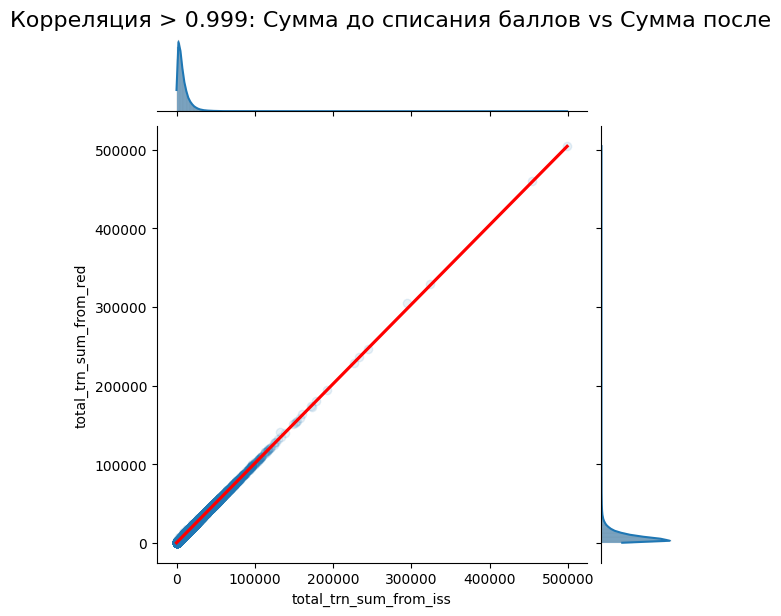

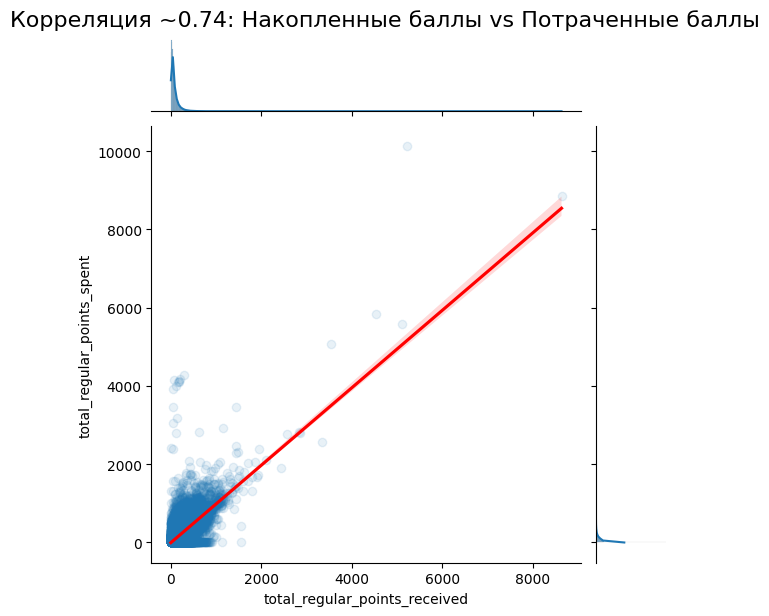

In [23]:
# Пара с самой сильной связью (почти 1.0)
# total_trn_sum_from_iss vs total_trn_sum_from_red
sns.jointplot(data=final_df_for_analysis, 
              x='total_trn_sum_from_iss', 
              y='total_trn_sum_from_red', 
              kind='reg',
              joint_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
plt.suptitle('Корреляция > 0.999: Сумма до списания баллов vs Сумма после', y=1.02, fontsize=16)
plt.show()


# Пара с интересной связью
# total_regular_points_received vs total_regular_points_spent
sns.jointplot(data=final_df_for_analysis, 
              x='total_regular_points_received', 
              y='total_regular_points_spent', 
              kind='reg',
              joint_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
plt.suptitle('Корреляция ~0.74: Накопленные баллы vs Потраченные баллы', y=1.02, fontsize=16)
plt.show()

### Выводы по анализу корреляций

На основе тепловой карты и программного поиска пар с абсолютным коэффициентом корреляции > 0.7, мы выделили несколько ключевых "кластеров" признаков и сделали некоторые выводы.

**Кластер 1: Абсолютная корреляция > 0.95**

Эта группа признаков демонстрирует почти идеальную линейную зависимость, что говорит о функциональной связи.

-   Корреляции между признаками `total_purchase_sum`, `total_trn_sum_from_iss`, `total_trn_sum_from_red` превышают 0.99. Эти признаки являются разными  измерениями общего объема трат клиента. Наиболее ценную информацию в себе несет `total_purchase_sum` - общая сумма покупки.
-   `avg_transaction_amount` и `transaction_amount_q0.75` (**0.97**), а также для `q0.5` (**0.96**). Средний чек очень сильно определяется медианой и верхним квантилем, что указывает на относительную стабильность трат у клиентов.

В дальнейшем оставлять эту группу нельзя в связи с тем, что это вызовет мультиколлинеарность, которая сломает линейную модель. Поэтому стоит выделить по одному представителю для каждой из подгрупп.

**Кластер 2: Абсолютная корреляция 0.8 - 0.95**

Эта группа обладает сильной структурной связью.

-   `total_purchase_sum` vs `total_regular_points_received` (**0.91**): Прямое отражение механики программы лояльности.
-   `total_purchase_sum` vs `total_products_purchased` (**0.93**): Клиенты, тратящие больше, покупают больше товаров.
-   `total_purchase_sum` vs `unique_products_count` (**0.86**): Покупатели с большим оборотом также имеют более широкие интересы.
-   `avg_transaction_amount` vs `avg_regular_points_per_transaction` (**0.87**): Отражение той же механики лояльности, но на уровне среднего чека.

Аналогично первой группе, эта группа также содержит высокую степень избыточности, так как признаки несут очень похожую информацию и вызывают мультиколлинеарность, хотя и не идентичны.

**Кластер 3: Абсолютная корреляция 0.7 - 0.8**

Интересный диапазон корреляций, так как связи в нем связи имеют уже поведенческий характер и могут раскрывать интересные инсайты.

-   `total_regular_points_received` vs `total_regular_points_spent` (**0.74**): Данная пара показывает, что клиенты, которые активно копят баллы, также активно их и тратят. 
-   `total_express_points_received` vs `avg_express_points_per_transaction` (**0.78**): Связь между общим количеством экспресс-баллов и их средним начислением за транзакцию.

Признаки в этой группе менее избыточны и могут в дальнейшем представлять пользу для модели. Особенно стоит обратить внимание на пару `total_regular_points_received` vs `total_regular_points_spent`, так как она несет информацию о действии списания, а не просто о накоплении, что может быть ценным для модели, несмотря на корреляцию.

Для сохранения интерпретируемости признаков, на данном этапе мы не будем пользоваться PCA, ограничившись корректировками исходя корреляционного анализа. 

Удалим два признака, дублирующие метрики баллов в отношении к товару (`total_trn_sum_from_iss` и `total_trn_sum_from_red`). Из метрик среднего чека оставим квантиль 0.5, так как он характеризует стабильность покупок клиента и их разброс. На основе среднего чека выделим меру того, сколько в среднем сохраняет стоимости покупки один бонусный балл - `avg_transaction_amount_per_point`. И выделим из метрик трат баллов общий баланс на клиента.

In [24]:
# Определим, какие бизнес-метрики мы полагаем объединить для получения новых признаков
final_df_for_analysis['total_purchase_sum_per_product'] = final_df_for_analysis['total_purchase_sum']/final_df_for_analysis['total_products_purchased']
final_df_for_analysis['total_regular_points_balance'] = final_df_for_analysis['total_regular_points_received']-final_df_for_analysis['total_regular_points_spent']
final_df_for_analysis['total_express_points_balance'] = final_df_for_analysis['total_express_points_received']-final_df_for_analysis['total_express_points_spent']
final_df_for_analysis['avg_transaction_amount_per_point'] = final_df_for_analysis['avg_transaction_amount']/final_df_for_analysis['avg_regular_points_per_transaction']
final_df_for_analysis_reducted = final_df_for_analysis.drop(
    columns = ['total_trn_sum_from_iss','total_trn_sum_from_red',
             'transaction_amount_q0.75','transaction_amount_q0.25','total_purchase_sum','total_products_purchased',
             'avg_regular_points_per_transaction','total_regular_points_received',
             'total_regular_points_spent','total_express_points_received','total_express_points_spent',
             'avg_transaction_amount','avg_regular_points_per_transaction'])

ЗДЕСЬ НУЖНО ПОСМОТРЕТЬ КОРРЕЛЯЦИЮ НЕЧИСЛОВЫХ ПРИЗНАКОВ....

In [25]:
# Это добавить выше: убрать признак гендера и сделать дамми-признаки числовыми
final_df_for_analysis_reducted['gender_F'] = final_df_for_analysis_reducted['gender_F'].astype(int)
final_df_for_analysis_reducted['gender_M'] = final_df_for_analysis_reducted['gender_M'].astype(int)
final_df_for_analysis_reducted['gender_U'] = final_df_for_analysis_reducted['gender_U'].astype(int)
final_df_for_analysis_reducted = final_df_for_analysis_reducted.drop(columns = ['gender'])

# Распределения таргета\тритмента\групп

In [26]:
class TargetScore:
    """
    «Одна фича -> одно число» + единый график сравнения.
    Числовые:    score = |corr(feature, target)|
    Бинарные:    score = |mean(target|1) - mean(target|0)|
    Категориальные: score = weighted std таргет-рейтов по категориям
    """

    def __init__(self, target_col: str, ignore_dates: bool = True):
        self.target_col = target_col
        self.ignore_dates = ignore_dates

    def summarize(self, df: pd.DataFrame) -> pd.DataFrame:
        t = self.target_col
        assert t in df.columns, f"Нет столбца таргета: {t}"
        y = df[t].astype(float)

        features = [c for c in df.columns if c != t]
        rows = []

        for f in features:
            s = df[f]
            kind = self._kind(s)
            if kind == "datetime" and self.ignore_dates:
                continue

            if kind == "numeric":
                x = pd.to_numeric(s, errors="coerce")
                m = self._safe_corr(x, y)
                score = abs(m) if pd.notna(m) else 0.0
                rows.append({
                    "feature": f, "kind": kind,
                    "score": score, "sign": m,
                    "note": "abs(Pearson corr)"
                })

            elif kind == "binary":
                x = s.astype(float)
                r1 = y[x==1].mean() if (x==1).any() else np.nan
                r0 = y[x==0].mean() if (x==0).any() else np.nan
                diff = (r1 - r0) if pd.notna(r1) and pd.notna(r0) else np.nan
                rows.append({
                    "feature": f, "kind": kind,
                    "score": abs(diff) if pd.notna(diff) else 0.0,
                    "sign": diff,
                    "note": "rate(1)-rate(0)"
                })

            else:  # categorical
                g = df.groupby(f)[t].mean() # таргет-рейт по категории
                w = df[f].value_counts(normalize=True).reindex(g.index).fillna(0.0)
                # взвешенная дисперсия отклонений от общего среднего
                mu = y.mean()
                var = ((g - mu)**2 * w).sum()
                spread = float(np.sqrt(var))
                rng = float(g.max() - g.min()) if len(g) > 0 else np.nan
                rows.append({
                    "feature": f, "kind": "categorical",
                    "score": spread,# основной компаратор
                    "sign": np.nan,# у spread знака нет
                    "note": f"weighted std across {len(g)} cats; range={rng:.4f}" if len(g)>0 else "no cats"
                })

        out = pd.DataFrame(rows).sort_values("score", ascending=False).reset_index(drop=True)
        return out

    def plot(self, summary: pd.DataFrame, top_k: int = 30):
        """
        Единый bar-чарт: топ-K фич по score. Ничего не сохраняет, просто показывает.
        """
        if summary.empty:
            print("summary пуст.")
            return
        sub = summary.head(top_k).iloc[::-1]  # снизу-вверх
        plt.figure(figsize=(10, max(4, 0.45*len(sub))))
        plt.barh(sub["feature"].astype(str), sub["score"].values)
        plt.xlabel("score (сравнимая сила связи с таргетом)")
        plt.title(f"Топ-{len(sub)} признаков по 'одному числу' (без бинов)")
        plt.tight_layout()
        plt.show()
    def _kind(self, s: pd.Series) -> str:
        if pd.api.types.is_datetime64_any_dtype(s): return "datetime"
        if pd.api.types.is_bool_dtype(s): return "binary"
        if pd.api.types.is_numeric_dtype(s):
            # бинарные как numeric поймаем правилом ниже
            vals = set(pd.Series(s).dropna().unique().tolist())
            if len(vals) <= 2 and vals.issubset({0,1}): return "binary"
            return "numeric"
        return "categorical"
    def _safe_corr(self, a: pd.Series, b: pd.Series) -> float:
        a = a.astype(float)
        mask = a.notna() & b.notna()
        a, b = a[mask], b[mask]
        if a.size < 2: return np.nan
        if np.isclose(a.std(ddof=0), 0) or np.isclose(b.std(ddof=0), 0):
            return np.nan
        return float(a.corr(b))


c:\Users\Daniil\dev\uplift\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Daniil\dev\uplift\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\Daniil\dev\uplift\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2913: RuntimeWarning: invalid value encountered in dot
  c = dot(X, X_T.conj())
c:\Users\Daniil\dev\uplift\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Daniil\dev\uplift\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\Daniil\dev\uplift\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2913: RuntimeWarning: invalid value encountered in dot
  c = dot(X, 

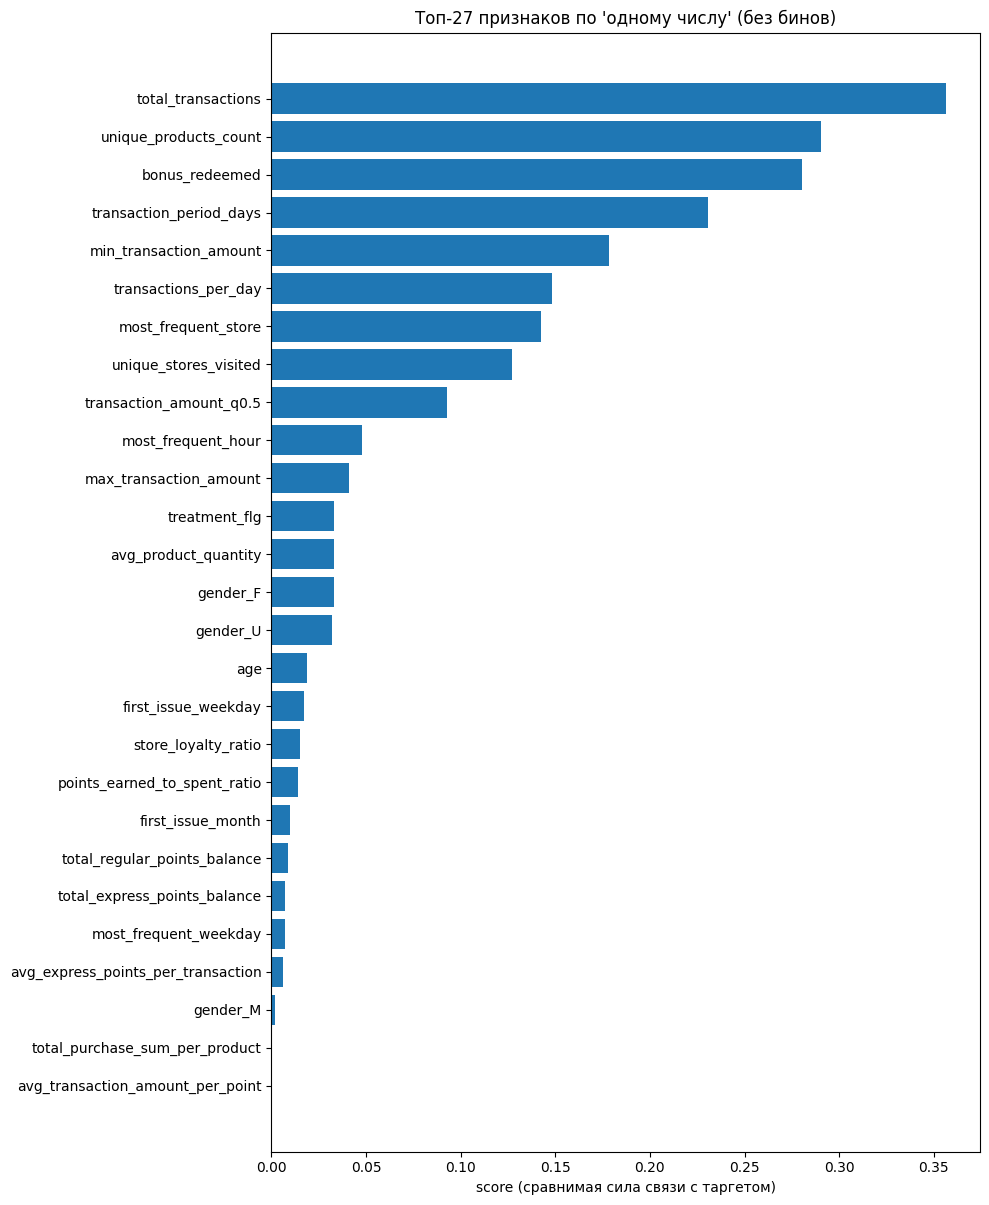

In [31]:
mapper = TargetScore(target_col="target", ignore_dates=True)
summary_target = mapper.summarize(final_df_for_analysis_reducted)
mapper.plot(summary_target, top_k=30)

In [28]:
summary_target

,feature,kind,score,sign,note
0,total_transactions,numeric,0.356609,0.356609,abs(Pearson corr)
1,unique_products_count,numeric,0.290271,0.290271,abs(Pearson corr)
2,bonus_redeemed,binary,0.280476,0.280476,rate(1)-rate(0)
3,transaction_period_days,numeric,0.230674,0.230674,abs(Pearson corr)
4,min_transaction_amount,numeric,0.178185,-0.178185,abs(Pearson corr)
5,transactions_per_day,numeric,0.148106,0.148106,abs(Pearson corr)
6,most_frequent_store,categorical,0.142582,NaN,weighted std across 13787 cats; range=1.0000
7,unique_stores_visited,numeric,0.127131,0.127131,abs(Pearson corr)
8,transaction_amount_q0.5,numeric,0.092721,-0.092721,abs(Pearson corr)
9,most_frequent_hour,numeric,0.047894,0.047894,abs(Pearson corr)


**Интерпретация распределения таргета по признакам**

Этот анализ показывает, **насколько каждый признак связан с вероятностью того, что `target = 1`**. Для каждого признака вычислено одно число — `score`, которое отражает **силу различимости**: чем выше `score`, тем сильнее изменяется доля таргета при изменении признака.

**Что означает `score` для разных типов признаков:**

- **Числовые признаки** (`total_transactions`, `age`, `transaction_period_days` и др.)  
  `score` = абсолютная корреляция `|corr(feature, target)|`. Это мера линейной связи между значением признака и вероятностью события.  
  Чем ближе `score` к 1, тем сильнее зависимость. Знак (`sign`) показывает направление:  
  - `sign > 0` — при росте признака вероятность `target=1` увеличивается;  
  - `sign < 0` — при росте признака вероятность `target=1` снижается.

- **Бинарные признаки** (`bonus_redeemed`, `gender_F`, `treatment_flg` и др.)  
  `score` = разница долей таргета между группами: score = | mean(target|feature=1) - mean(target|feature=0) |
  Чем больше эта разница, тем сильнее признак разделяет целевые и нецелевые группы.

- **Категориальные признаки** (`most_frequent_store`)  
  `score` = разброс (взвешенное стандартное отклонение) таргет-рейтов между категориями. Если все категории ведут себя одинаково, `score` близок к 0. Если доля таргета заметно различается между категориями — `score` высокий.  
  Например, `most_frequent_store` имеет `score ≈ 0.14`, но при этом 13 787 категорий — значит, различия есть, но это, скорее всего, шум   а не реальный информативный сигнал.

**Интерпретация результатов:**

| Диапазон `score` | Интерпретация | Признаки |
|------------------:|:--------------|:------------------|
| **> 0.25** | Сильная связь с таргетом. Признак явно объясняет вероятность события. | `total_transactions`, `unique_products_count`, `bonus_redeemed` |
| **0.10 – 0.25** | Средняя связь. Влияет, но не определяюще. | `transaction_period_days`, `transactions_per_day`, `unique_stores_visited` |
| **< 0.05** | Слабая или отсутствующая связь. Таргет распределён равномерно. | `age`, `gender_F/M/U`, `first_issue_month`, `points_balance` |

Таким образом, основные «драйверы» таргета — это **показатели активности**: чем чаще клиент взаимодействует (больше транзакций, разнообразие товаров, использование бонусов), тем выше вероятность целевого события. А демография, даты и балансовые показатели почти не влияют на поведение.

`NaN` в `sign` означает, что направление зависимости невозможно определить. 
Это значит, что признак категориальный (у него нет «направления роста»).

**Краткий вывод:**

`score` можно понимать как **силу влияния признака на распределение таргета**. Это не модельный вес и не статистическая значимость, а эмпирическая мера различимости: насколько сильно вероятность `target = 1` меняется при изменении конкретного признака. Чем выше `score`, тем больше этот признак объясняет разницу между целевыми и нецелевыми объектами.


In [29]:
# Находим признаки с нулевым скором
zero_score_features = summary_target.loc[summary_target["score"] ==0, "feature"].tolist()
print(f"Признаков с нулевым score: {len(zero_score_features)}")
print(zero_score_features)
final_df_for_analysis_new = final_df_for_analysis_reducted.drop(columns=zero_score_features, errors="ignore")
final_df_for_analysis_new = final_df_for_analysis_new.drop(columns='most_frequent_store') #предполагаем как шум

Признаков с нулевым score: 2
['total_purchase_sum_per_product', 'avg_transaction_amount_per_point']


ОСТАЛОСЬ СТАТЗНАЧ ТАРГЕТА ОТ ТРИТМЕНТА И РАСПРЕДЕЛЕНИЕ ТАРГЕТА ПО ТРИТМЕНТУ

# Propencity-score

In [30]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
from sklift.models import ClassTransformationReg

ТУТ БУДЕТ МОДЕЛЬ....